In [1]:
import os
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
import keras.backend as K
from tensorflow.keras.applications import densenet
import tensorflow.keras.layers as kl
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.layers import Layer
#import keras_tuner

import itertools
import sklearn.metrics

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedGroupKFold
#from keras_tuner.tuners import BayesianOptimization
#from keras_tuner import Objective
#from keras_tuner_cv.utils import pd_inner_cv_get_result

#Optimizer options
from tensorflow.keras.optimizers import Adam

2024-03-29 16:59:55.247751: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-29 16:59:55.366175: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-29 16:59:56.990801: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
from sklearn.utils import resample

In [3]:
import tensorflow as tf
import cv2
from imgaug import augmenters as iaa
from skimage.exposure import match_histograms

import collections
collections.Iterable = collections.abc.Iterable
import numpy as np
import random
np.bool = np.bool_
np.complex = np.complex_

import argparse
import os
import sys
import time

In [4]:
os.chdir("/localscratch/hrechter.18211959.0")

In [5]:
#%% Define mask insertion function
'''
Function from StackOverflow user Ben: https://stackoverflow.com/users/59850/ben
https://stackoverflow.com/questions/40895785/using-opencv-to-overlay-transparent-image-onto-another-image
'''
def add_transparent_image(background, foreground, x_offset=None, y_offset=None):
    bg_h, bg_w, bg_channels = background.shape
    fg_h, fg_w, fg_channels = foreground.shape

    assert bg_channels == 3, f'background image should have exactly 3 channels (RGB). found:{bg_channels}'
    assert fg_channels == 4, f'foreground image should have exactly 4 channels (RGBA). found:{fg_channels}'

    # center by default
    if x_offset is None: 
        x_offset = (bg_w - fg_w) // 2
    else:
        centre_x = (bg_w - fg_w) // 2
        x_offset = x_offset + centre_x
        
    if y_offset is None: 
        y_offset = (bg_h - fg_h) // 2
    else:
        centre_y = (bg_h - fg_h) // 2
        y_offset = y_offset + centre_y

    w = min(fg_w, bg_w, fg_w + x_offset, bg_w - x_offset)
    h = min(fg_h, bg_h, fg_h + y_offset, bg_h - y_offset)

    if w < 1 or h < 1: return

    # clip foreground and background images to the overlapping regions
    bg_x = max(0, x_offset)
    bg_y = max(0, y_offset)
    fg_x = max(0, x_offset * -1)
    fg_y = max(0, y_offset * -1)
    foreground = foreground[fg_y:fg_y + h, fg_x:fg_x + w]
    background_subsection = background[bg_y:bg_y + h, bg_x:bg_x + w]

    # separate alpha and color channels from the foreground image
    foreground_colors = foreground[:, :, :3]
#    foreground_colors = match_histograms(foreground_colors, background, channel_axis=-1)
    alpha_channel = foreground[:, :, 3] / 255  # 0-255 => 0.0-1.0

    # construct an alpha_mask that matches the image shape
    alpha_mask = np.dstack((alpha_channel, alpha_channel, alpha_channel))

    # combine the background with the overlay image weighted by alpha
    composite = background_subsection * (1 - alpha_mask) + foreground_colors * alpha_mask

    # overwrite the section of the background image that has been updated
    background[bg_y:bg_y + h, bg_x:bg_x + w] = composite
    return background

In [6]:
#%% Define augmentation functions
mask_augs = iaa.Sequential([iaa.Resize((0.09, 0.17), interpolation="area"), #area interpolation is best for shrinking images
        iaa.SomeOf((1, 2), [  # Random number between 0, 2
        iaa.Fliplr(0.5),  # Horizontal flips                     0.01
        iaa.Rotate((-10, 10)),
        ], random_order=True)], random_order = True)

Winter_aug = iaa.SomeOf((1, 3), [  # Random number between 0, 3
        iaa.weather.Clouds(),
        iaa.weather.Fog(),
        iaa.weather.Snowflakes()
        ], random_order=True)

small_aug = iaa.SomeOf((1, 3), [  # Random number between 0, 3
        iaa.Fliplr(0.5),  # Horizontal flips                     0.01
        iaa.Multiply((0.95, 1.05), per_channel=0.2),  # Brightness multiplier per channel    0.05
        iaa.Grayscale(alpha=(0.1, 1.0)),  # Random Grayscale conversion          0.17        
        iaa.LinearContrast((0.75, 1.5)),  # Contrast Normalization               0.95
        ], random_order=True)

train_aug = iaa.SomeOf((1, 3), [  # Random number between 0, 3
        iaa.Fliplr(0.5),  # Horizontal flips                     0.01
        # Random channel increase and rotation 0.03
        iaa.Add((-5, 5)),  # Overall Brightness                   0.04
        iaa.Multiply((0.95, 1.05), per_channel=0.2),  # Brightness multiplier per channel    0.05
        iaa.Sharpen(alpha=(0.1, 0.75), lightness=(0.85, 1.15)),  # Sharpness                            0.05
        iaa.WithColorspace(to_colorspace='HSV', from_colorspace='RGB',  # Random HSV increase                  0.09
                           children=iaa.WithChannels(0, iaa.Add((-30, 30)))),
        iaa.WithColorspace(to_colorspace='HSV', from_colorspace='RGB',
                           children=iaa.WithChannels(1, iaa.Add((-30, 30)))),
        iaa.WithColorspace(to_colorspace='HSV', from_colorspace='RGB',
                           children=iaa.WithChannels(2, iaa.Add((-30, 30)))),
        iaa.AddElementwise((-10, 10)),  # Per pixel addition                   0.11
        iaa.CoarseDropout((0.0, 0.02), size_percent=(0.02, 0.25)),  # Add large black squares              0.13
        iaa.GaussianBlur(sigma=(0.1, 1.0)),  # GaussianBlur                         0.14
        iaa.Grayscale(alpha=(0.1, 1.0)),  # Random Grayscale conversion          0.17
        iaa.Dropout(p=(0, 0.1), per_channel=0.2),  # Add small black squares              0.17
        iaa.AdditiveGaussianNoise(scale=(0.0, 0.05 * 255), per_channel=0.5),
        # Add Gaussian per pixel noise         0.26
        iaa.ElasticTransformation(alpha=(0, 1.0), sigma=0.25),  # Distort image by rearranging pixels  0.70
        iaa.LinearContrast((0.75, 1.5)),  # Contrast Normalization               0.95
        iaa.weather.Clouds(),
        iaa.weather.Fog(),
  #      iaa.weather.Rain()
    ], random_order=True)

In [7]:
#%%
class TrainingDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, df, crops, X_col, y_col,
                 batch_size, model_name,
                 shuffle=True, inserts=False, 
                 weights=None, night_weights=None):

        self.df = df.copy()
        self.crops = crops.copy()
#        print(len(df), flush=True)
        self.X_col = X_col
        self.y_col = y_col
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.model = model_name
        self.inserts=inserts
        self.n = len(self.df)
        if self.inserts==False:
            self.n_id = df[y_col['id']].nunique()
        elif self.inserts==True:
            self.n_id = ((df[y_col['id']].nunique())-2)
            self._weights=weights
            self._night_weights=night_weights
    #        self.night_weights.pop(3)
#            print(self.weights, flush=True)
 #           print(self.night_weights, flush=True)
        self.n_domain = df[y_col['domain']].nunique()


    # Shuffling upon epoch end if flagged
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

    def __insert_augs(self, path, night, spp):
#        rolld6 = np.random.randint(0,6)
 #       print(rolld6)
#        print(self._weights, flush=True)
#        print(self._night_weights, flush=True)
        if spp==-1:
            rolld6=(random.choices([0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 21, 22, 23, 25, 28, 29, 30, 31, 32, 33, 34, 35], weights=self._weights, k=1))[0]
            nightd4=(random.choices([0, 1, 4, 6, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32, 33], weights=self._night_weights, k=1))[0]
        if spp==-2:
#            rolld6=(random.choices([0, 1, 2, 3, 4, 5], k=1))[0]
            rolld6=(random.choices([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 21, 22, 23, 25, 28, 29, 30, 31, 32, 33, 34, 35], k=1))[0]
#            nightd4=(random.choices([0, 1, 2, 4, 5], k=1))[0]
            nightd4=(random.choices([0, 1, 2, 4, 6, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32, 33], k=1))[0]
        if night==True:
            image = cv2.imread(path)
           # rolld4=np.random.choice([0, 1, 4, 5])
   #         print(self.night_weights, flush=True)
#            rolld5=(random.choices([0, 1, 2, 4, 5], k=1))[0]
            crop_index = self.crops.loc[(self.crops.Night==True) & (self.crops.id==nightd4)].sample(n=1).index
#            crop_index = self.crops[self.crops.Night==True].sample(n=1, replace=False).index
            crop_index = crop_index[0]
        elif night==False:
            image_og = cv2.imread(path)
            image = cv2.imread(path)
   #         print(self.weights, flush=True) 
#            rolld6=(random.choices([0, 1, 2, 3, 4, 5], k=1))[0]
#            rolld4 = np.random.choice([0, 3, 4, 5])
            crop_index = self.crops.loc[(self.crops.Night==False) & (self.crops.id==rolld6)].sample(n=1).index
#            crop_index = self.crops[self.crops.Night==False].sample(n=1, replace=False).index
            crop_index = crop_index[0]
        cpath = self.crops.iloc[crop_index, 0]
 #       print(("Crop 1:", cpath), flush=True)
        crop = cv2.imread(('crops/' + cpath), cv2.IMREAD_UNCHANGED)
#        print(crop, flush=True)
        spp_name = self.crops.iloc[crop_index, 2]
        species = self.crops.iloc[crop_index, 3]
#        species = self.crops['id'][crop_index]
        crop_aug = mask_augs.augment_image(crop)

        y_jitter=np.random.randint(-7, 40)
        x_jitter=np.random.randint(-85, 85)
        image = add_transparent_image(image, crop_aug, x_offset=x_jitter, y_offset=y_jitter)
#        print(image)
    #    if night ==True:
  #          noise = iaa.Sequential([iaa.AdditiveGaussianNoise(scale=(0, 5))])
   #         image = noise.augment_image(image)
#        if night==False:
 #           image = match_histograms(image, image_og, channel_axis=-1)
        image = cv2.rectangle(image, (0,0), (244,52), (0,0,0), -1) # 52 pixels on top and bottom Black infobar)
        image = cv2.rectangle(image, (0,172), (244,244), (0,0,0), -1) # 52 pixels on top and bottom Black infobar)

        rolld100=np.random.randint(1, 101)
        if rolld100==100: #Save 1% of created images for verification
            file = path.rsplit('/')[-1]
            if not os.path.exists("Results/augmentations/"):
                os.makedirs("Results/augmentations/")
            cv2.imwrite("Results/augmentations/" + spp_name + "_" + file, image)
        image_arr = image.astype("float32")
        return image_arr, species

    #Reads image and normalizes it
    def __get_input(self, path):
        image = tf.keras.utils.load_img("AHC/" + path)
        image_arr = tf.keras.utils.img_to_array(image)
        image_arr = small_aug.augment_image(image_arr.astype("uint8")).astype("float32")
        return image_arr/255

    #Reads image and normalizes it
    def __get_insert_input(self, x):
        path=x[0]
        empty=x[1]
        night=x[2]
        spp=x[3]
        if empty==True:
            image_arr, x[3] = self.__insert_augs(path, night, spp)
        else:
            image = tf.keras.utils.load_img("AHC/" + path)
            image_arr = tf.keras.utils.img_to_array(image)
        image_arr = small_aug.augment_image(image_arr.astype("uint8")).astype("float32")
        spp = x[3]
        label = tf.keras.utils.to_categorical(spp, 36)
        return image_arr/255, label

    #One-hot encoding of label
    def __get_output(self, label, num_classes):
        return tf.keras.utils.to_categorical(label, num_classes=num_classes)

    #Generates batch_size samples of data
    def __get_data(self, batches):
        # Generates data containing batch_size samples
        path_batch = batches[self.X_col['path']]
        name_batch = batches[self.y_col['id']]

        if self.inserts==True:
            empty_batch = batches[self.X_col['Empty']]
            night_batch = batches[self.X_col['Night']]
            x_batches=np.array([path_batch, empty_batch, night_batch, name_batch])
            x_batches=np.stack(x_batches,axis=1)

            batch_tuple = np.asarray([self.__get_insert_input(x) for x in x_batches])
            X_batch, y0_batch = zip(*batch_tuple)
            X_batch = np.array(X_batch)
            y0_batch= np.array(y0_batch)

        else:
            X_batch = np.asarray([self.__get_input(x) for x in path_batch])
            y0_batch = np.asarray([self.__get_output(y, self.n_id) for y in name_batch])

        if self.model in ('DenseNet201', 'CNN'):
            return X_batch, y0_batch
        elif self.model in ('DANNseNet201', 'DANN'):
            sin_season_batch = batches[self.y_col['sin_date']]
            cos_season_batch = batches[self.y_col['cos_date']]
            y1_batch = np.asarray([y for y in zip(sin_season_batch, cos_season_batch)])
            return X_batch, tuple([y0_batch, y1_batch])
        elif self.model in ('CatDANN', 'catDANN'):
            domain_batch = batches[self.y_col['domain']]
            y1_batch = np.asarray([self.__get_output(y, 4) for y in domain_batch])
            return X_batch, tuple([y0_batch, y1_batch])

    #Returns data batches as tuple
    def __getitem__(self, index):

        batches = self.df[index * self.batch_size:(index + 1) * self.batch_size]
        X, y = self.__get_data(batches)    

        return X, y

    #Returns number of batches
    def __len__(self):
        return self.n // self.batch_size

In [8]:
class ValidationDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, df, X_col, y_col,
                 batch_size, model_name,
                 shuffle=True):
        
        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.model = model_name
        self.n = len(self.df)
        self.n_id = ((df[y_col['id']]).nunique())
        self.n_domain = df[y_col['domain']].nunique()
    # Shuffling upon epoch end if flagged
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
    
    #Reads image and normalizes it
    def __get_input(self, path):

        image = tf.keras.utils.load_img("AHC/" + path)
        image_arr = tf.keras.utils.img_to_array(image)
        return image_arr/255.
   
    #One-hot encoding of label
    def __get_output(self, label, num_classes):
        return tf.keras.utils.to_categorical(label, num_classes=num_classes)
    
    #Generates batches of data
    def __get_data(self, batches):
        # Generates data containing batch_size samples
        path_batch = batches[self.X_col['path']]
        name_batch = batches[self.y_col['id']]
        X_batch = np.asarray([self.__get_input(x) for x in path_batch])
        y0_batch = np.asarray([self.__get_output(y, self.n_id) for y in name_batch])

        if self.model in ('DenseNet201', 'CNN'):
            return X_batch, y0_batch
        elif self.model in ('DANNseNet201', 'DANN'):
            sin_season_batch = batches[self.y_col['sin_date']]
            cos_season_batch = batches[self.y_col['cos_date']]
            y1_batch = np.asarray([y for y in zip(sin_season_batch, cos_season_batch)])
            return X_batch, tuple([y0_batch, y1_batch])
        elif self.model in ('CatDANN', 'catDANN'):
            domain_batch = batches[self.y_col['domain']]
            y1_batch = np.asarray([self.__get_output(y, 4) for y in domain_batch])
            return X_batch, tuple([y0_batch, y1_batch])
    
    #Returns data batches as tuple
    def __getitem__(self, index):
        
        batches = self.df[index * self.batch_size:(index + 1) * self.batch_size]
        X, y = self.__get_data(batches)    
        
        return X, y
    
    #Returns number of batches
    def __len__(self):
        return self.n // self.batch_size

In [9]:
from lrfinder import LRFinder

In [10]:
df = pd.read_csv("AHC_data.csv")
df['id'] = df['id']-1
allAHC = pd.read_csv("AHC_all.csv")
allAHC['id'] = allAHC['id']-1
crops = pd.read_csv("crops.csv")
empties = pd.read_csv("empties.csv")

In [11]:
def get_group(train_df, group):
    """
    Stratified Group K-fold cross validation requires an extra group around which to split the data.
    This function returns that group data as an array. 
    
    Inputs:
    - traindf: str, the metadata CSV containing annotations for the images. 
    
    - group: str, set which location margin to divide the dataset by for cross validation.
    Options: 
        - "CTloc" - K-fold will split data down to singular CT stations. This is the smallest split of data.
        - "CTtype" - K-fold will split data down to CT study area and area type, three per CT area. ie. PT_RAF, PT_TRV, PT_ROW.
        - "areatype" - K-fold will split data down to area type, three overall. ie. RAF, TRV, ROW.
        - "studyarea" - K-fold will split data down to CT study area. This is the largest split of all data. ie. PT, SC, SV, GL.
    
    Returns:
        out (numpy.ndarray): array-like of shape [n_samples,]
        
    """
    
 #   train_df = pd.read_csv(traindf)

    if group in ("CTloc"):
        CTloc_train = np.array(train_df['Camera_loc'])
        return CTloc_train
    elif group in ("CTtype"):
        CTtype_train = np.array(train_df['Camera_type'])
        return CTtype_train
    elif group in ("Ecoregion"):
        Ecoregion_train = np.array(train_df['Ecoregion'])
        return Ecoregion_train
    elif group in ("studyarea"):
        studyarea_train = np.array(train_df['study_area'])
        return studyarea_train
    

In [12]:
#group = get_group(allAHC, "CTloc")
group=None
#kfold = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
group_name="CTRand"

In [13]:
Y = np.array(allAHC['id'])
num_classes = 36
BATCH=256

In [14]:
#%%
def model_build():
    model = densenet.DenseNet201(weights="imagenet", include_top=False, input_shape=(224,224,3), pooling="avg")
    model.trainable = False
    regularizer = None
    
    out = kl.Dense(256, activation="relu", kernel_regularizer=regularizer)(model.layers[-1].output)
    out = kl.Dropout(0.0)(out)

    out = kl.Dense(256, activation='relu')(out)
    out = kl.Dropout(0.0)(out)

    spp_class = kl.Dense(num_classes, activation='softmax', name="spp_class")(out)

    model = tf.keras.Model(inputs=model.inputs,
                           outputs=spp_class)

    return model

In [15]:
def plot_loss(n_skip_beginning=10, n_skip_end=5, x_scale='log'):
    """
    Plots the loss.
    Parameters:
        n_skip_beginning - number of batches to skip on the left.
        n_skip_end - number of batches to skip on the right.
        """
    learning_rates = lr_finder.get_learning_rates()
    losses = lr_finder.get_losses()

    f, ax = plt.subplots()
    ax.set_ylabel("loss")
    ax.set_xlabel("learning rate (log scale)")
    ax.plot(learning_rates[n_skip_beginning:-n_skip_end],
            losses[n_skip_beginning:-n_skip_end])
    ax.set_xscale(x_scale)
    return(ax)

In [16]:
def balance_dataset(df, column='string'):
    max_cat = df[[column]].value_counts().reset_index(name='count').at[0, column]
    max_count = len(df.loc[df[column]==max_cat])
    df_balanced = pd.DataFrame()
    
    for cat in df[column].unique():
        df_sample = df[df[column] == cat]

        temp = resample(df_sample, 
                        replace=True,           # sample with replacement
                        n_samples=max_count,    # to match majority class
                        random_state=42,        # reproducible results
                        stratify=df_sample['path']) 

        # Combine majority class with upsampled minority class
        df_balanced = pd.concat([df_balanced, temp])
 
    return df_balanced

In [17]:
model = model_build()

2024-03-29 17:00:31.555769: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31141 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:b3:00.0, compute capability: 7.0


In [18]:
lr=1e-6
opt=Adam(learning_rate=lr)
loss="categorical_crossentropy"

metrics=["accuracy",
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.Recall(name="recall")]
model.compile(optimizer=opt, loss=loss, metrics=metrics)

In [26]:
for split, (train_index, val_index) in enumerate(kfold.split(allAHC, Y, group)):
    
    train_df = allAHC.iloc[train_index]
    val_df = allAHC.iloc[val_index]

/home/hrechter/AIenv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


In [38]:
bal_df=balance_dataset(train_df, 'Species')

In [50]:
allAHCnight=allAHC[['id', 'Night']].value_counts()


In [52]:
allAHCnight.to_csv("AHCspp_night.csv")

In [20]:
def get_train_weights(train_df):
    class_weights = []
    deer = len(train_df.loc[train_df['id']==2])

    train_sample = (deer*36)-len(train_df)
    class_weights.append((deer - len(train_df.loc[train_df['id']==0]))/train_sample)
    class_weights.append((deer - len(train_df.loc[train_df['id']==1]))/train_sample)
    for i in range(3, 36):
        class_weights.append((deer - len(train_df.loc[train_df['id']==i]))/train_sample)
    return class_weights, train_sample

In [24]:
BATCH=1024

/tmp/ipykernel_40505/1511266195.py:134: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  batch_tuple = np.asarray([self.__get_insert_input(x) for x in x_batches])


In [22]:
for split, (train_index, val_index) in enumerate(kfold.split(allAHC, Y, group)):
    train_df = allAHC.iloc[train_index]
    val_df = allAHC.iloc[val_index]
    
    train_weights, train_sample = get_train_weights(train_df)
    train_weights.pop(18)
    train_weights.pop(22)
    train_weights.pop(23)
    train_weights.pop(23)
    print("N empties: " + str(train_sample))
    night_weights = (get_train_weights(train_df))[0]
    night_weights.pop(3)
    night_weights.pop(4)
    night_weights.pop(5)
    night_weights.pop(7)
    night_weights.pop(10)
    night_weights.pop(27)
    night_weights.pop(28)
    
    
    if group_name in ("CTloc"):
        train_group = np.unique(group[train_index])
        val_group = np.unique(group[val_index])
        train_empties=empties.loc[empties['Camera_loc'].isin(train_group)]
        val_empties = empties.loc[empties['Camera_loc']. isin(val_group)]
        val_empties['id']=-2
    else:
        train_empties = empties.copy()
    train_empties=train_empties.sample(train_sample, replace=True)
    train_empties['id']=-1
    

    add_empties = [train_df, train_empties] #, val_empties]
    train_df = pd.concat(add_empties)
#    train_df=balance_dataset(train_df, 'Species')

    traingen = TrainingDataGenerator(df=train_df, crops= crops,
                                             batch_size = BATCH,
                                             y_col = {'id': 'id', 'domain': 'domain', 
                                                      'sin_date': 'sin_doy', 'cos_date': 'cos_doy'},
                                             X_col = {'path': 'path', 'Empty': 'Empty', 'Night': 'Night'},
                                             model_name="DenseNet201",
                                             shuffle = True, inserts=True, weights=train_weights, night_weights=night_weights)
    valgen = ValidationDataGenerator(val_df,
                                         batch_size = BATCH,
                                         y_col = {'id': 'id', 'domain': 'domain', 
                                                  'sin_date': 'sin_doy', 'cos_date': 'cos_doy'},
                                         X_col = {'path': 'path'},
                                         model_name="DenseNet201",
                                         shuffle = True)
    
    STEPS_PER_EPOCH = np.ceil(len(train_df) / BATCH)
    lr_finder = LRFinder(model)
    lr_finder.find(traingen, start_lr=1e-4, end_lr=1e-1, epochs=5, steps_per_epoch=STEPS_PER_EPOCH, validation_data=valgen)
    print("Fold: " + str(split))
    best_lr = lr_finder.get_best_lr(sma=20)
    best_2 = lr_finder.get_best_lr(n_skip_beginning=25, n_skip_end=5, sma=20)
    best_3 = lr_finder.get_best_lr(n_skip_beginning=45, n_skip_end=5, sma=20)
    print("Best lr: " + str(best_lr))
    print("Best lr2: " + str(best_2))
    print("Best lr3: " + str(best_3), flush=True)
    axs = plot_loss()
    axs.axvline(x=best_lr, c='r', linestyle='-.')
    axs.axvline(x=best_2, c='b', linestyle='-.')
    axs.axvline(x=best_3, c='g', linestyle='-.')

/home/hrechter/AIenv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


N empties: 133307
N empties: 133307
N empties: 133270
N empties: 133270
N empties: 133270


N empties: 133270


/tmp/ipykernel_40505/1511266195.py:134: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  batch_tuple = np.asarray([self.__get_insert_input(x) for x in x_batches])


Epoch 1/3


2024-03-29 17:07:08.106972: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


146/146 [==============================] - ETA: 0s - loss: 3.1587 - accuracy: 0.1422 - precision: 0.8652 - recall: 0.0255 

2024-03-29 17:36:10.423648: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


146/146 [==============================] - 1755s 12s/step - loss: 3.1587 - accuracy: 0.1422 - precision: 0.8652 - recall: 0.0255 - val_loss: 2.6183 - val_accuracy: 0.2896 - val_precision: 0.5025 - val_recall: 0.0493
Epoch 2/3
146/146 [==============================] - 1683s 12s/step - loss: 2.5692 - accuracy: 0.2895 - precision: 0.8134 - recall: 0.1387 - val_loss: 1.7783 - val_accuracy: 0.5083 - val_precision: 0.7402 - val_recall: 0.3005
Epoch 3/3
146/146 [==============================] - 1677s 11s/step - loss: 3.5821 - accuracy: 0.1567 - precision: 0.4791 - recall: 0.0777 - val_loss: 3.6598 - val_accuracy: 0.0771 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Fold: 4
Best lr: 0.0013257116
Best lr2: 0.0013257116
Best lr3: 0.0013257116


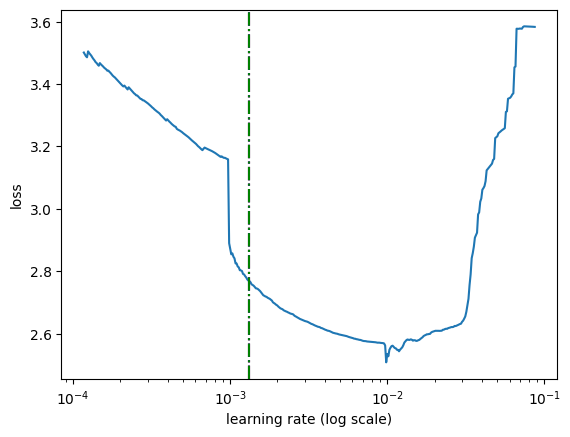

In [27]:
train_weights, train_sample = get_train_weights(train_df)
train_weights.pop(18)
train_weights.pop(22)
train_weights.pop(23)
train_weights.pop(23)
print("N empties: " + str(train_sample))
night_weights = (get_train_weights(train_df))[0]
night_weights.pop(3)
night_weights.pop(4)
night_weights.pop(5)
night_weights.pop(7)
night_weights.pop(10)
night_weights.pop(27)
night_weights.pop(28)


if group_name in ("CTloc"):
    train_group = np.unique(group[train_index])
    val_group = np.unique(group[val_index])
    train_empties=empties.loc[empties['Camera_loc'].isin(train_group)]
    val_empties = empties.loc[empties['Camera_loc']. isin(val_group)]
    val_empties['id']=-2
else:
    train_empties = empties.copy()
train_empties=train_empties.sample(train_sample, replace=True)
train_empties['id']=-1


add_empties = [train_df, train_empties] #, val_empties]
train_df = pd.concat(add_empties)

traingen = TrainingDataGenerator(df=train_df, crops= crops,
                                     batch_size = BATCH,
                                     y_col = {'id': 'id', 'domain': 'domain', 
                                              'sin_date': 'sin_doy', 'cos_date': 'cos_doy'},
                                     X_col = {'path': 'path', 'Empty': 'Empty', 'Night': 'Night'},
                                     model_name="DenseNet201",
                                     shuffle = True, inserts=True, weights=train_weights, night_weights=night_weights)
valgen = ValidationDataGenerator(val_df,
                                     batch_size = BATCH,
                                     y_col = {'id': 'id', 'domain': 'domain', 
                                              'sin_date': 'sin_doy', 'cos_date': 'cos_doy'},
                                     X_col = {'path': 'path'},
                                     model_name="DenseNet201",
                                     shuffle = True)

STEPS_PER_EPOCH = np.ceil(len(train_df) / BATCH)
lr_finder = LRFinder(model)
lr_finder.find(traingen, start_lr=1e-4, end_lr=1e-1, epochs=3, steps_per_epoch=STEPS_PER_EPOCH, validation_data=valgen)
print("Fold: " + str(split))
best_lr = lr_finder.get_best_lr(sma=20)
best_2 = lr_finder.get_best_lr(n_skip_beginning=25, n_skip_end=5, sma=20)
best_3 = lr_finder.get_best_lr(n_skip_beginning=45, n_skip_end=5, sma=20)
print("Best lr: " + str(best_lr))
print("Best lr2: " + str(best_2))
print("Best lr3: " + str(best_3), flush=True)
axs = plot_loss()
axs.axvline(x=best_lr, c='r', linestyle='-.')
axs.axvline(x=best_2, c='b', linestyle='-.')
axs.axvline(x=best_3, c='g', linestyle='-.')

In [57]:
STEPS_PER_EPOCH = np.ceil(len(train_df) / BATCH)
lr_finder = LRFinder(model)
lr_finder.find(traingen, start_lr=1e-5, end_lr=1, epochs=5, steps_per_epoch=STEPS_PER_EPOCH)
fig = plot_loss()
best_lr = lr_finder.get_best_lr(sma=20)
print("Best lr: " + str(best_lr), flush=True)

Epoch 1/5


2024-03-29 11:54:12.584003: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


 20/523 [>.............................] - ETA: 5:33 - loss: 3.2710 - accuracy: 0.1643 - precision: 1.0000 - recall: 0.0045

KeyboardInterrupt: 

In [43]:
traingen = TrainingDataGenerator(df=bal_df, crops= crops,
                                         batch_size = BATCH,
                                         y_col = {'id': 'id', 'domain': 'domain', 
                                                  'sin_date': 'sin_doy', 'cos_date': 'cos_doy'},
                                         X_col = {'path': 'path', 'Empty': 'Empty', 'Night': 'Night'},
                                         model_name="DenseNet201",
                                         shuffle = True, inserts=False) #, weights=train_weights, night_weights=night_weights)
valgen = ValidationDataGenerator(val_df,
                                     batch_size = BATCH,
                                     y_col = {'id': 'id', 'domain': 'domain', 
                                              'sin_date': 'sin_doy', 'cos_date': 'cos_doy'},
                                     X_col = {'path': 'path'},
                                     model_name="DenseNet201",
                                     shuffle = True)

0.0009999999


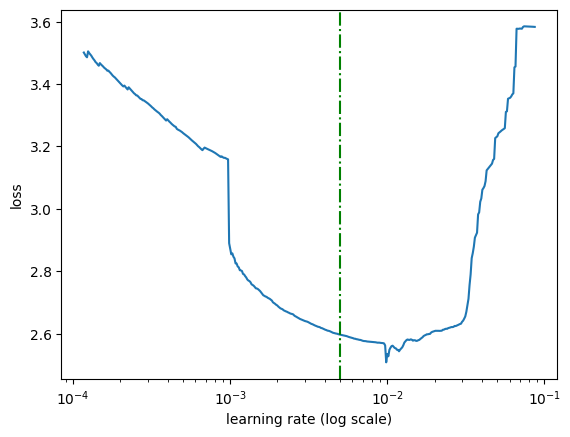

In [44]:
axs = plot_loss()
axs.axvline(x=0.005, c='g', linestyle='-.')
print(lr_finder.get_best_lr(n_skip_beginning=20, n_skip_end=290, sma=20))

In [82]:
for split, (train_index, val_index) in enumerate(kfold.split(df, Y, group)):
    
    train_df = df.iloc[train_index]
    val_df = df.iloc[val_index]

    y_train = np.array(train_df['id'])

  #  val_group = np.unique(group[val_index])
  #  empties = empties.loc[empties['Camera_loc']. isin(val_group)]
    empties=empties.sample(1000, replace=False)
    add_empties = [train_df, empties]
    train_df = pd.concat(add_empties)

#    paths, X_train, y_train = get_data(train_df)
 #   testpaths, X_test, y_test = get_data(val_df)
    
    traingen = TrainingDataGenerator(df=train_df, crops= crops,
                                     batch_size = BATCH,
                                     y_col = {'id': 'id', 'domain': 'domain', 
                                              'sin_date': 'sin_doy', 'cos_date': 'cos_doy'},
                                     X_col = {'path': 'path', 'Empty': 'Empty', 'Night': 'Night'},
                                     model_name="DenseNet201",
                                     shuffle = True, inserts=False)
    valgen = ValidationDataGenerator(val_df,
                                     batch_size = BATCH,
                                     y_col = {'id': 'id', 'domain': 'domain', 
                                              'sin_date': 'sin_doy', 'cos_date': 'cos_doy'},
                                     X_col = {'path': 'path'},
                                     model_name="DenseNet201",
                                     shuffle = True)